In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from vachoppy.trajectory import LatticeHopping
from vachoppy.fingerprint import FingerPrint, CosineDistance

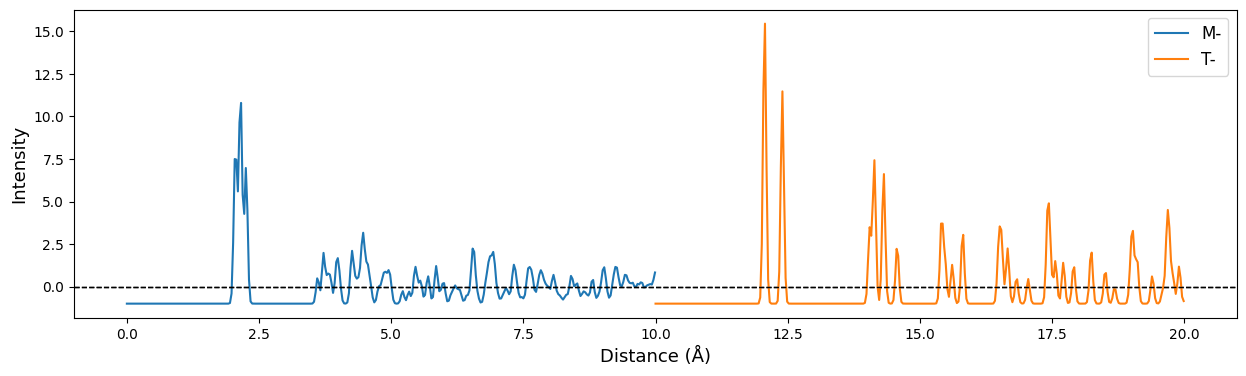

In [14]:
# Rmax, delta, sigma = 20, 0.004, 0.1
Rmax, delta, sigma = 10, 0.03, 0.03

fp_m = FingerPrint(A='Hf', 
                   B='O', 
                   poscar='poscars_hfo2/POSCAR_mHfO2', 
                   Rmax=Rmax, 
                   delta=delta, 
                   sigma=sigma)

fp_t = FingerPrint(A='Hf', 
                   B='O', 
                   poscar='poscars_hfo2/POSCAR_tHfO2', 
                   Rmax=Rmax, 
                   delta=delta, 
                   sigma=sigma)

# plot fingerprints
plt.figure(figsize=(15, 4))
fp_m.plot_fingerprint(disp=False, label='M-')
fp_t.plot_fingerprint(disp=False, R=fp_t.R+Rmax, label='T-')
plt.show()

In [15]:
poscar_perf = 'xdatcar.2200K/POSCAR_SUPERCELL'
xdatcar = 'xdatcar.2200K/XDATCAR_02'

traj = LatticeHopping(poscar_perf=poscar_perf,
                      xdatcar=xdatcar,
                      interval=50,
                      target='O')

# generate POSCAR files
step = np.arange(traj.num_step)
for i in step:
    traj.save_poscar(step=i, outdir='./poscars_traj')
print("POSCAR files were generated.")

# save fingerprints
fp_traj = []
for i in tqdm(range(traj.num_step),
              desc='fingerprints:'):
    fp_i = FingerPrint(A='Hf', 
                       B='O', 
                       poscar=f'poscars_traj/POSCAR_{i}', 
                       Rmax=Rmax, 
                       delta=delta, 
                       sigma=sigma)
    fp_traj += [fp_i]

POSCAR files were generated.


fingerprints::   0%|          | 0/300 [00:00<?, ?it/s]

possible step of transition : 215


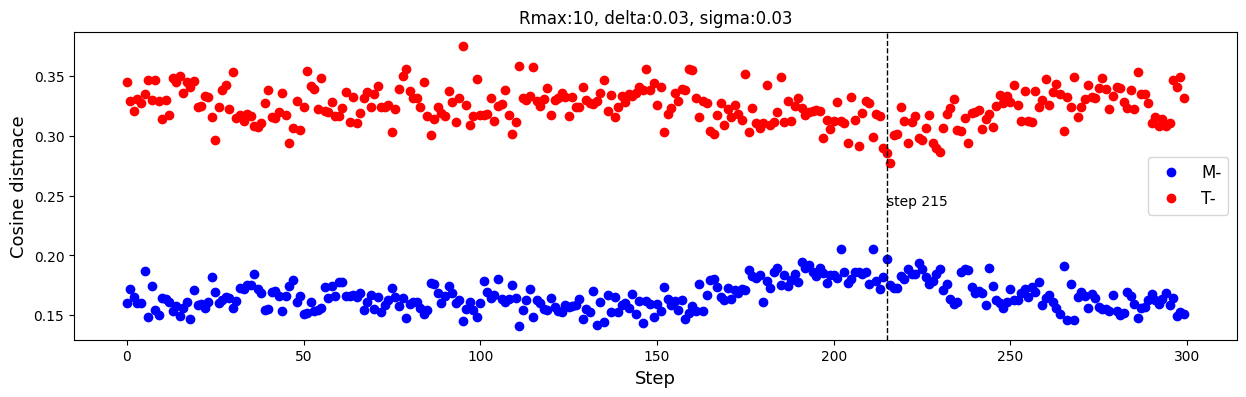

In [18]:
dist_m = np.zeros(traj.num_step)
dist_t = np.zeros(traj.num_step)

for i, fp_i in enumerate(fp_traj):
    dist_m[i] = CosineDistance(fp_m.fingerprint, fp_i.fingerprint)
    dist_t[i] = CosineDistance(fp_t.fingerprint, fp_i.fingerprint)

# plot cosine distance
plt.figure(figsize=(15, 4))

step = np.arange(traj.num_step)

plt.plot(step, dist_m, 'bo', label='M-')
plt.plot(step, dist_t, 'ro', label='T-')

step_nearest = np.argmin(dist_t-dist_m)
print(f"possible step of transition : {step_nearest}")
plt.axvline(step_nearest, 0, 1, color='k', linestyle='--', linewidth=1)

y_txt = (dist_m[step_nearest]+dist_t[step_nearest])/2
plt.text(step_nearest, y_txt, s=f"step {step_nearest}")

plt.xlabel("Step", fontsize=13)
plt.ylabel('Cosine distnace', fontsize=13)

plt.legend(fontsize=12)
plt.title(f"Rmax:{Rmax}, delta:{delta}, sigma:{sigma}")

outfile = f"distance_{Rmax}_{delta}_{sigma}.png"
plt.savefig(outfile, dpi=300)
plt.show()